In [53]:
%matplotlib inline
import datetime
import os
import re
import sys
import gc

import gdal
from numpy import asarray, zeros, ma, flipud, pi, exp, cos, radians
# import matplotlib
# import matplotlib.pyplot as plt
# from matplotlib.mlab import find
# matplotlib.use('Agg')
from pylab import *

# from PIL import Image
from scipy.signal import wiener
import pyresample as pr
# from pyproj import Proj
from scipy.interpolate import RectSphereBivariateSpline
import simplekml
import multiprocessing

sys.path.append('/media/SOLabNFS2/tmp/sentinel/')

import readS1
from readS1 import *
import distancelib
import gshhs_rasterize

sys.path.append('/usr/bin')
from gdal2tiles import GDAL2Tiles

# sys.path.append(
#     os.path.dirname(
#         os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
#     )
# )
from big_image import save_big_image
sys.path.append('/home/mag/Documents/repos/solab/PySOL/cmod/')

__author__ = 'Alexander Myasoedov'
__email__ = 'mag@rshu.ru'
__created__ = datetime.datetime(2014, 10, 28)
__modified__ = datetime.datetime(2015, 6, 19)
__version__ = "1.0"
__status__ = "Development"

In [54]:
def mkdirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)

def PR_Mouche(theta, phi):
    A_0 = 0.00650704
    B_0 = 0.128983
    C_0 = 0.992839
    A_HALF_PI = 0.00782194
    B_HALF_PI = 0.121405
    C_HALF_PI = 0.992839
    A_PI = 0.00598416
    B_PI = 0.140952
    C_PI = 0.992885

    P_0 = A_0 * exp(B_0 * theta) + C_0
    P_HALF_PI = A_HALF_PI * exp(B_HALF_PI * theta) + C_HALF_PI
    P_PI = A_PI * exp(B_PI * theta) + C_PI

    C0 = (P_0 + P_PI + 2 * P_HALF_PI) / 4
    C1 = (P_0 - P_PI) / 2
    C2 = (P_0 + P_PI - 2 * P_HALF_PI) / 4

    P = C0 + C1 * cos(radians(phi)) + C2 * cos(radians(2 * phi))

    return P

def ncepGFSmodel2swath(lats, lons, data, lats_2, lons_2):
    func = RectSphereBivariateSpline(lats, lons, data)
    data_2 = func.ev(
        lats_2.ravel()*pi/180, lons_2.ravel()*pi/180
    ).reshape(lats_2.shape)
    return data_2

def create_KML_asar(area_extent, savepath):
    kml = simplekml.Kml()

    pol = kml.newpolygon(name='area_extent', visibility=1)
    pol.tessellate = 1

    pol.altitudemode = 'clampToGround'
    pol.outerboundaryis.coords = [(min(area_extent[0], area_extent[2]),
                                   min(area_extent[1], area_extent[3])),
                                  (max(area_extent[0], area_extent[2]),
                                   max(area_extent[1], area_extent[3]))]
    if type(savepath) == list:
        for _savepath in savepath:
            kml.save(_savepath)
    else:
        kml.save(savepath)

def create_asar_tiles(png_filename, tiles_output_dir, proj):
    local_argv = ['/usr/bin/gdal2tiles.py', '-p', 'raster', '-r', 'cubic',
                  '-s', proj, png_filename, tiles_output_dir]
    argv = gdal.GeneralCmdLineProcessor(local_argv)
    if argv:
        gdal2tiles = GDAL2Tiles(argv[1:])
        gdal2tiles.process()

In [55]:
def processingS1(inpath, fn):
    s1 = readS1(inpath=inpath, fn=fn)
    # s1.__dict__['raw_counts']

    # get vars from s1 class
    # polarization
    # raw_counts
    # incidenceAngle_2
    # sigmaNought_2
    # noiseLut_2
    # sigma0
    # lons_2
    # lats_2
    # GEOgrid
    # cLUTs
    # nLUTs
    # manifest
    polarization = s1.polarization
    incidenceAngle_2 = s1.incidenceAngle_2
    sigma0 = s1.sigma0
    lons_2 = s1.lons_2
    lats_2 = s1.lats_2
    GEOgrid = s1.GEOgrid
    manifest = s1.manifest

    del s1
    gc.collect()

    scale = 1

    sigma0w = {}
    roughness = {}

    print "Scale set to: \'%s\' " % scale

    for p in polarization:
        print "Filtering Image: \'%s\' polarization" % p

        # filter the image
        sigma0w[p] = wiener(
            sigma0[p][::scale, ::scale], mysize=(7, 7), noise=None
        )
        # sigma0w[p] = sigma0[p]

    del sigma0
    gc.collect()

    # S1 Pixel resolution
    # we use pxlResSAR for further GSHHS rasterizing and
    # reprojecting data with pyresample

    lonlim = (lons_2[::scale, ::scale].min(), lons_2[::scale, ::scale].max())
    latlim = (lats_2[::scale, ::scale].min(), lats_2[::scale, ::scale].max())

    # enlarge lonlims for cropping a bit larger area for masking
    lonlimGSHHS = (lonlim[0]-1.0, lonlim[1]+1.0)
    latlimGSHHS = (latlim[0]-1.0, latlim[1]+1.0)

    # Get first guess pixel resolution
    pxlResSARm = asarray(
        distancelib.getPixelResolution(
            lats_2[::scale, ::scale], lons_2[::scale, ::scale],
            lons_2[::scale, ::scale].shape, 'km'
        )
    )*1e3
    pxlResSARdeg = asarray(
        distancelib.getPixelResolution(
            lats_2[::scale, ::scale], lons_2[::scale, ::scale],
            lons_2[::scale, ::scale].shape, 'deg'
        )
    )

    # Define areas with pyresample
    swath_def = pr.geometry.SwathDefinition(
        lons=lons_2[::scale, ::scale], lats=lats_2[::scale, ::scale]
    )

    area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326',
                                   proj='eqc', lonlim=lonlimGSHHS,
                                   latlim=latlimGSHHS, ellps="WGS84",
                                   res=pxlResSARm)

    # Get the SAR pixel resolution from the area_def
    # for further identical shapes
    up = min(latlimGSHHS)
    down = max(latlimGSHHS)
    left = min(lonlimGSHHS)
    right = max(lonlimGSHHS)
    area_extent_deg = (left, down, right, up)

    area_extent_deg_shape = area_def_4326.shape

    pxlResSARdeg = asarray(
        (abs(area_extent_deg[2] - area_extent_deg[0]) /
            float(area_extent_deg_shape[1]),
         abs(area_extent_deg[3] - area_extent_deg[1]) /
            float(area_extent_deg_shape[0]))
    )

    pxlResSARm = asarray(
        (area_def_4326.pixel_size_x, area_def_4326.pixel_size_y)
    )
    print "S1 cell resolution, %s deg" % str(pxlResSARdeg)
    print "S1 cell resolution, %s m" % str(pxlResSARm)

    # Apply Mask from GSHHS
    reload(gshhs_rasterize)

    # ESRI shapefile containing land polygons
    shapefile = '/media/SOLabNFS/store/auxdata/coastline/GSHHS_shp/f/GSHHS_f_L1.shp'

    # reproject GSHHS onto S1 grid before calculations
    print "Rasterizing Land Mask"
    mask_arr_4326 = gshhs_rasterize.gshhs_rasterize_4326(
        lonlimGSHHS, latlimGSHHS, pxlResSARdeg, area_def_4326.shape,
        True, shapefile
    )

    del pxlResSARdeg

    mask_arr_swath = pr.kd_tree.resample_nearest(
        area_def_4326, mask_arr_4326.ravel(), swath_def,
        radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None
    )

    print area_def_4326.shape, mask_arr_4326.shape
    print mask_arr_swath.shape, sigma0w[p].shape, swath_def.shape

    # Nice Image (Roughness)
    sigma0wAvg = {}
    roughnessNrmlzd = {}

    if len(polarization[0]) >= 2:  # if 2 polarizations
        for p in polarization:
            print "Nice Image: \'%s\' polarization" % p
            roughness[p] = ma.masked_where(mask_arr_swath, sigma0w[p])
            sigma0wAvg[p] = ma.median(roughness[p], axis=0)
            roughnessNrmlzd[p] = (roughness[p]-sigma0wAvg[p])/sigma0wAvg[p]
    elif len(polarization[0]) == 1:  # if only 1 polarization
        p = polarization
        print "Nice Image: \'%s\' polarization" % p
        roughness[p] = ma.masked_where(mask_arr_swath, sigma0w[p])
        sigma0wAvg[p] = ma.median(roughness[p], axis=0)
        roughnessNrmlzd[p] = (roughness[p]-sigma0wAvg[p])/sigma0wAvg[p]

    del roughness, sigma0wAvg

    # Adding Model wind

    # import xmltodict

    # zf = zipfile.ZipFile(inpath+fn, 'r')
    # manifest = zf.read(fn[:-4] + '.SAFE/manifest.safe')
    # manifest = xmltodict.parse(manifest) # Parse the read document string
    # zf.close()

    startTime = datetime.datetime.strptime(
        manifest['xfdu:XFDU']['metadataSection']['metadataObject'][12]['metadataWrap']['xmlData']['safe:acquisitionPeriod']['safe:startTime'],
        "%Y-%m-%dT%H:%M:%S.%f"
    )

    ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)

    # Reprojecting data
    # Pixel resolution
    # we use pxlResWind/pxlResSAR for further pyresample
    # radius_of_influence and sigmas
    pxlResWind = asarray(
        distancelib.getPixelResolution(
            ncepGFSmodelWind['lats_wind'],
            ncepGFSmodelWind['lons_wind'],
            ncepGFSmodelWind['lons_wind'].shape, 'km'
        )
    )

    # Note pxlResWind is in KM, multiply by 1e3 for meters
    print "S1 cell resolution, %s m" % pxlResSARm
    print "Wind cell resolution, %s km" % pxlResWind

    # reproject NCEP onto S1 grid before calculations
    # Using RectSphereBivariateSpline - Bivariate spline
    # approximation over a rectangular mesh on a sphere
    # as it is much more efficiant for full resolution
    # as well as smoothes nicely the image

    # We don't want to work with full res wind so scaling
    # the image for about 100m resolution
    # Adjust scale to get appropriate value

    lts = flipud(ncepGFSmodelWind['lats_wind'])[:, 0]*pi/180
    lns = ncepGFSmodelWind['lons_wind'][0, :]*pi/180

    lts_2 = lats_2[::scale, ::scale]
    lns_2 = lons_2[::scale, ::scale]

    ncepGFSmodelWindSwath = {}
    ncepGFSmodelWindSwath['wind_speed'] = ncepGFSmodel2swath(
        lts, lns, flipud(ncepGFSmodelWind['wind_speed']), lts_2, lns_2
    )
    ncepGFSmodelWindSwath['wind_dir'] = ncepGFSmodel2swath(
        lts, lns, flipud(ncepGFSmodelWind['wind_dir']),   lts_2, lns_2
    )
    ncepGFSmodelWindSwath['u'] = ncepGFSmodel2swath(
        lts, lns, flipud(ncepGFSmodelWind['u']), lts_2, lns_2
    )
    ncepGFSmodelWindSwath['v'] = ncepGFSmodel2swath(
        lts, lns, flipud(ncepGFSmodelWind['v']), lts_2, lns_2
    )

    pxlResWindSwath = asarray(
        distancelib.getPixelResolution(lts_2, lns_2, lns_2.shape, 'km')
    )

    print "Interpolated Wind cell resolution, %s km" % pxlResWindSwath

    # calculate bearing from initial lats/lons for further wind calculation
    # Taking initial values as bearing is more accurate after
    # interpolation than vice versa
    bearing = zeros((GEOgrid['lons'].shape[0]-1, GEOgrid['lons'].shape[1]))

    for n in range(0, GEOgrid['lons'].shape[1]):
        col = ([GEOgrid['lats'][:-1, n], GEOgrid['lons'][:-1, n]],
               [GEOgrid['lats'][1:, n], GEOgrid['lons'][1:, n]])
        for m in range(0, GEOgrid['lons'].shape[0]-1):
            bearing[m][n] = distancelib.bearing(
                asarray(col[0])[:, m], asarray(col[1])[:, m]
            )

    # interpolate to raw_counts.shape
    bearing_2 = imresize(bearing, ncepGFSmodelWindSwath['wind_dir'].shape)

    # NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!
    p = polarization[0]

    wind_dir_model_swath_rel = 90 + bearing_2 -\
        ncepGFSmodelWindSwath['wind_dir']

    del bearing, bearing_2

    if p == 'hh':
        PR = PR_Mouche(
            incidenceAngle_2[p][::scale, ::scale], wind_dir_model_swath_rel
        )
        try:
            from cmod_gpu import rcs2windOpenCl
            wind_speed_asar = rcs2windOpenCl(
                sar=sigma0w[p]*PR, windir=wind_dir_model_swath_rel,
                theta=incidenceAngle_2[p][::scale, ::scale]
            )
        except Exception:
            from cmod_vect import rcs2windPar
            wind_speed_asar = rcs2windPar(
                sigma0w[p]*PR, cmdv=5, windir=wind_dir_model_swath_rel,
                theta=incidenceAngle_2[p][::scale, ::scale], nprocs=numProcs
            )
        del PR
    elif p == 'vv':
        try:
            from cmod_gpu import rcs2windOpenCl
            wind_speed_asar = rcs2windOpenCl(
                sar=sigma0w[p], windir=wind_dir_model_swath_rel,
                theta=incidenceAngle_2[p][::scale, ::scale]
            )
        except Exception:
            from cmod_vect import rcs2windPar
            wind_speed_asar = rcs2windPar(
                sigma0w[p], cmdv=5, windir=wind_dir_model_swath_rel,
                theta=incidenceAngle_2[p][::scale, ::scale], nprocs=numProcs
            )

    del sigma0w
    gc.collect()

    # Add mask to initial NCEP data
    area_def_ncep = pr.geometry.SwathDefinition(
        lons=ncepGFSmodelWind['lons_wind'], lats=ncepGFSmodelWind['lats_wind']
    )
    mask_arr_ncep = pr.kd_tree.resample_nearest(
        area_def_4326, mask_arr_4326.ravel(), area_def_ncep,
        radius_of_influence=4*pxlResWind.max(), epsilon=0.5, fill_value=None
    )

    del area_def_4326, mask_arr_4326, pxlResWind, area_def_ncep

    ncepGFSmodelWind['wind_speed'] = ma.masked_where(
        mask_arr_ncep, ncepGFSmodelWind['wind_speed']
    )

    # Add mask to ASAR wind and reprojected NCEP
    wind_speed_asar = ma.masked_where(mask_arr_swath, wind_speed_asar)
    ncepGFSmodelWindSwath['wind_speed'] = ma.masked_where(
        mask_arr_swath, ncepGFSmodelWindSwath['wind_speed']
    )

    del mask_arr_swath, ncepGFSmodelWind, mask_arr_ncep, ncepGFSmodelWindSwath
    gc.collect()

    # return_values = ['lats_2', 'lons_2', 'roughnessNrmlzd', 'wind_speed_asar',
                     # 'pxlResSARm', 'polarization', 'swath_def']

    return_values = {}
    return_values['lats'] = lats_2
    return_values['lons'] = lons_2
    return_values['roughnessNrmlzd'] = roughnessNrmlzd
    return_values['wind_speed_asar'] = wind_speed_asar
    return_values['pxlResSARm'] = pxlResSARm
    return_values['polarization'] = polarization
    return_values['swath_def'] = swath_def
    return return_values

In [56]:
inpath = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/Ania_Ladoga_29_May_2015/'
fileNameList = ['S1A_IW_GRDH_1SDV_20150603T154002_20150603T154027_006211_0081A9_5F10.zip',
                'S1A_IW_GRDH_1SDV_20150529T041657_20150529T041722_006131_007F51_F751.zip',
                'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.zip']

fn = fileNameList[0]

prog = re.compile(r'(\d{8})')
file_date = prog.findall(fn)[0]

year = file_date[:4]
month = file_date[4:6]
day = file_date[6:]
# day = '04'

print 'Start granule: ', fn

return_values = processingS1(inpath, fn)

print 'preprocessing done'
# for key in return_values:
#     locals()[key] = return_values[key]

lats = return_values['lats']
lons = return_values['lons']
roughnessNrmlzd = return_values['roughnessNrmlzd']
wind_speed_asar = return_values['wind_speed_asar']
pxlResSARm = return_values['pxlResSARm']
polarization = return_values['polarization']
swath_def = return_values['swath_def']

Start granule:  S1A_IW_GRDH_1SDV_20150603T154002_20150603T154027_006211_0081A9_5F10.zip
Available polarizations: '[u'vv', u'vh']'
Reading raw_counts: 'vv' polarization
Interpolating LUTs: 'vv' polarization
Reading raw_counts: 'vh' polarization
Interpolating LUTs: 'vh' polarization
Scale set to: '1' 
Filtering Image: 'vv' polarization
Filtering Image: 'vh' polarization
up, down, left, right:  63.0 59.0 26.0 33.0
S1 cell resolution, [  9.10613144e-05   8.93824683e-05] deg
S1 cell resolution, [ 10.13689915   9.95001086] m
Rasterizing Land Mask


MemoryError: 

In [20]:
import numpy as np
import numpy.ma as ma
import math
from netCDF4 import Dataset as ncDataset

In [21]:
def array_size_normalize(input_array):
    avail_resolution_list = [int(256*math.pow(2, i)) for i in range(15)]
    # print avail_resolution_list
    shape = input_array.shape
    # print 'shape: ', shape
    current_pixels = max(shape)
    # print 'current pixels: ', current_pixels
    necessary_pixels = min(filter(lambda x: current_pixels < x,
                                  avail_resolution_list))
    # print 'necessary_pixels: ', necessary_pixels

    source_array = input_array[:]

    # src =
    #
    # xxx
    # xxx
    #
    # top_array =
    #
    # xxx
    # xxx
    #
    # res =
    #
    # xxx
    # xxx
    # xxx
    # xxx
    #
    # right_array =
    #
    # x
    # x
    # x
    # x
    #
    # res 4x4 =
    #
    # xxxx
    # xxxx
    # xxxx
    # xxxx

    top_array = np.ma.masked_all((necessary_pixels-shape[0], shape[1]))

    right_array = np.ma.masked_all((necessary_pixels, necessary_pixels-shape[1]))

    source_array = ma.concatenate((top_array, source_array), axis=0)
    # print source_array.shape
    source_array = ma.concatenate((source_array, right_array), axis=1)
    # print source_array.shape

    del top_array, right_array
    return source_array

def create_base_tiles(input_array):
    number_tiles = input_array.shape[0]/256

    lines = []
    all_list = []

    for i in range(number_tiles):
        for j in range(number_tiles):
            # print '[%d:%d' % (j*256, (j+1)*256), ',%d:%d]'%(i*256, (i+1)*256)
            lines.append(input_array[j*256:(j+1)*256, i*256:(i+1)*256])

        all_list.append(lines)
        lines = []
    return all_list

def decrease_zoom(source_array):
    rows, cols = source_array.shape
    rows_2 = rows/2
    cols_2 = cols/2
    sh = rows_2, rows//rows_2, cols_2, cols//cols_2
    return source_array.reshape(sh).mean(-1).mean(1)

In [22]:
from numpy import ma

def write_tile_to_nc(nc_variable, tiles_array, variable, zoom, _min=0, _max=4,
                     polarization=None):
    # print len(tiles_array)
    for row_number in range(len(tiles_array)):
        tile_row = tiles_array[row_number]
        for col_number in range(len(tile_row)):
            m = tile_row[col_number]

            m = ma.where(m <= _min, _min + 0.0001, m)
            m = ma.where(m >= _max, _max, m)

            # 0-254 , 255 for mask
            m = (m-_min)/float(_max-_min) * (2**8-2)

            m = np.where(m.mask, (2**8-1), m)
            m = np.uint8(m)
            # m = np.ma.masked_where(m == 255, m)
            if polarization is None:
                nc_variable[variable, zoom, row_number, col_number, :] = m[:]
            else:
                nc_variable[variable, polarization, zoom,
                            row_number, col_number, :] = m[:]


def create_dataset(output_path, max_zoom, variables_list,
                   polarizations=None):
    if os.path.isfile(output_path):
        return ncDataset(output_path, 'a', format='NETCDF4')

    max_x_tiles = 2**max_zoom

    dataset = ncDataset(output_path, 'w', format='NETCDF4')
    dataset.createDimension('vars', len(variables_list))
    if polarizations is not None:
        dataset.createDimension('polarizations', 4)
    dataset.createDimension('zoom', max_zoom+1)
    dataset.createDimension('x', max_x_tiles)
    dataset.createDimension('y', max_x_tiles)
    dataset.createDimension('shape0', 256)
    dataset.createDimension('shape1', 256)

    if polarizations is not None:
        dims = ('vars', 'polarizations', 'zoom', 'x', 'y', 'shape0', 'shape1')
    else:
        dims = ('vars', 'zoom', 'x', 'y', 'shape0', 'shape1')

    vars_var = dataset.createVariable('Variables', 'string', ('vars',),
                                      zlib=True, complevel=6)
    vars_var[:] = np.array(variables_list, dtype='string')[:]

    if polarizations is not None:
        polar_var = dataset.createVariable('Polarizations', 'string',
                                           ('polarizations',),
                                           zlib=True, complevel=6)
        polar_var[:] = np.array(polarizations, dtype='string')[:]

    # u1 = NC_UBYTE 0-255
    dataset.createVariable('Data', 'u1', dims, zlib=True, complevel=6)
    return dataset

In [23]:
def create_nc_tiles(reprojected_array, variable, out_path, polarization=None):
    var_list = ['roughness', 'wind_speed']
    minmax = {'roughness': [-1, 1],
              'wind_speed': [0, 20]}

    polarization_list = ['hh', 'vv', 'hv', 'vh']

    if variable in var_list:
        variable_num = var_list.index(variable)
    else:
        print 'Variable not found in var_list'
        return False

    if polarization is not None:
        polarization_num = polarization_list.index(polarization)
    else:
        print 'Polarization not found in polarization_list'
        return False

    minmax_value = minmax[variable]
    # outDimVar[link_num, :] = varin[:]

    source_array = array_size_normalize(reprojected_array)

    number_tiles = source_array.shape[0]/256
    zoom_level = int(math.log(number_tiles, 2))
    print 'zoom_level: ', zoom_level

    dataset = create_dataset(out_path, zoom_level, var_list, polarization_list)
    datasetVar = dataset.variables['Data']

    for zoom in range(zoom_level, -1, -1):
        print 'Start zoom level %d' % zoom
        # print source_array.shape

        tiles_array = create_base_tiles(source_array)

        write_tile_to_nc(datasetVar, tiles_array, variable_num, zoom,
                         _min=minmax_value[0], _max=minmax_value[1],
                         polarization=polarization_num)
        del tiles_array

        if zoom:
            source_array = decrease_zoom(source_array)
        print
        gc.collect()

    dataset.close()

In [24]:
out_dir = '/media/SOLabNFS2/store/satellite/Sentinel_solab'
# nc_path = os.path.join(out_dir, year, month, day, fn+'.nc')
nc_path = os.path.join('/tmp', fn+'.nc')

area_def = swath_area_def(
    name='Temporal SWATH EPSG Projection 3413', proj='stere',
    lonlim=(lons.min(), lons.max()), latlim=(lats.min(), lats.max()),
    ellps="WGS84", res=pxlResSARm, lat_ts=70, lat_0=90, lon_0=-45
)
pxlResSARm_max = pxlResSARm.max()

# roughness
for p in polarization:
    print "Start polar: ", p
    roughness_res = pr.kd_tree.resample_nearest(
        swath_def, roughnessNrmlzd[p].ravel(), area_def,
        radius_of_influence=pxlResSARm_max,
        epsilon=0.5, nprocs=numProcs, fill_value=None
    )
    create_nc_tiles(roughness_res, 'roughness', nc_path, p)

# wind speed
p_ws = polarization[0]

print "Start wind speed, polar: ", p
wind_speed_res = pr.kd_tree.resample_nearest(
    swath_def, wind_speed_asar.ravel(), area_def,
    radius_of_influence=pxlResSARm_max,
    epsilon=0.5, nprocs=numProcs, fill_value=None
)
    
create_nc_tiles(wind_speed_res, 'wind_speed', nc_path, p_ws)

up, down, left, right:  62.0 60.0 27.0 32.0
11111111111
Start polar:  vv
zoom_level:  7
7
(32768, 32768)

6
(16384, 16384)

5
(8192, 8192)

4
(4096, 4096)

3
(2048, 2048)

2
(1024, 1024)

1
(512, 512)

0
(256, 256)

Start polar:  vh
zoom_level:  7
7
(32768, 32768)

6
(16384, 16384)

5
(8192, 8192)

4
(4096, 4096)

3
(2048, 2048)

2
(1024, 1024)

1
(512, 512)

0
(256, 256)

zoom_level:  7
7
(32768, 32768)

6
(16384, 16384)

5
(8192, 8192)

4
(4096, 4096)

3
(2048, 2048)

2
(1024, 1024)

1
(512, 512)

0
(256, 256)



In [52]:
# roughnessNrmlzd['vv'].shape
# roughness_res_test = pr.kd_tree.resample_nearest(
#     swath_def, roughnessNrmlzd[p], area_def,
#     radius_of_influence=pxlResSARm_max,
#     epsilon=0.5, nprocs=numProcs, fill_value=None
# )
# (roughness_res_test == roughness_res).all()

True

In [37]:
from netCDF4 import Dataset as ncDataset
dataset = ncDataset(nc_path)
# data = dataset.variables['Data']

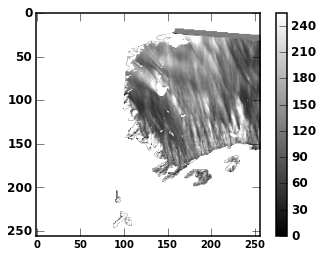

In [38]:
r = dataset.variables['Data'][0,1,2,0,2,:]
# r = dataset.variables['Data'][0,1,1,0,1,:]
r = np.ma.masked_where(r == 255, r)
gray()
imshow(r, vmin=0, vmax=255)
colorbar()
show()

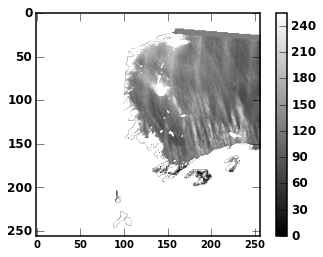

In [39]:
r = dataset.variables['Data'][0,3,2,0,2,:]
r = np.ma.masked_where(r >= 255, r)
gray()
imshow(r, vmin=0, vmax=255)
colorbar()
show()

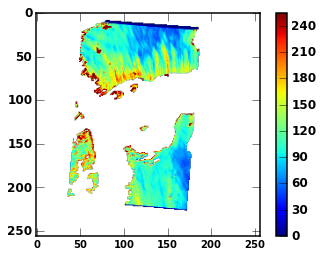

In [40]:
r = dataset.variables['Data'][1,1,1,0,1,:]
r = np.ma.masked_where(r >= 255, r)
jet()
imshow(r, vmin=0, vmax=255)
colorbar()
show()

In [44]:
dataset.close()

In [42]:
dataset = ncDataset(nc_path, 'a', format='NETCDF4')

In [1]:
dataset.ncattrs()
dataset.setncattr(name, value)

NameError: name 'dataset' is not defined